In [1]:
import numpy
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
# import numbaprocess
import copy
import glob
from numba import njit
import pandas
import glob
import pickle
import matplotlib

In [2]:
def request(rqdict, source, remove_file=True):
    t0 = time.time()

    c = cdsapi.Client()
    r = c.retrieve(
        source,rqdict)
    print('Request took: ' + str(time.time() - t0) + ' seconds')
    if True:
        r.download(target='download.zip')
        assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./download/')
    z.close()
    
    
    files = glob.glob('./download/*.nc')
    
    if files[0].split('/')[-1].startswith('IGRA'):
        ds = xarray.open_dataset(files[0])            
        data = ds.to_dataframe()
        for i in files[1:]:
            ds = xarray.open_dataset(i)            
            data = data.append(ds.to_dataframe())

    else:
        data=eua.CDMDataset(files[0]).to_dataframe()
        for i in files[1:]:
            da = eua.CDMDataset(i).to_dataframe()
            data = data.append(da)
            
    os.remove('download.zip')
    if remove_file:
        try:
           shutil.rmtree('./download/')
        except:
           print('Error while deleting directory')

    return data

In [21]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 10),
         'axes.labelsize': 20,
         'axes.titlesize': 24,
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

In [39]:
def cost(lon, lat, values):
    """ Estimate Cost between Points

    Parameters
    ----------
    lon         array/list      Longitudes
    lat         array/list      Latitudes
    values      array/list      Values

    Returns
    -------
    float   Cost
    """
    import numpy as np
    n = lon.shape[0]
    cost = np.zeros((n))
    for i in range(n):
        # Distance of all points * difference of values
        #
        cost[i] = np.nansum((distance(lon[i], lat[i], lat, lon) * (values[i] - values)) ** 2)

    return cost  # np.nansum(cost)/np.sum(np.isfinite(values))


def distance(ilon, ilat, lats, lons):
    """ Calculate Distance between one point and others

    Parameters
    ----------
    ilon
    ilat
    lats
    lons

    Returns
    -------
    array   Distances
    """
    import numpy as np
    ix = np.cos(ilat * np.pi / 180.) * np.cos(ilon * np.pi / 180.)
    iy = np.cos(ilat * np.pi / 180.) * np.sin(ilon * np.pi / 180.)
    iz = np.sin(ilat * np.pi / 180.)
    x = np.cos(lats * np.pi / 180.) * np.cos(lons * np.pi / 180.)
    y = np.cos(lats * np.pi / 180.) * np.sin(lons * np.pi / 180.)
    z = np.sin(lats * np.pi / 180.)
    dists = ix * x + iy * y + iz * z
    return np.arccos(dists * 0.999999)

In [42]:
# def points(lon, lat, labels=None, values=None, markersize=80, ocean=True, land=True, coastlines=True, rivers=False,
#            grid=True, posneg=False, extent=None, lloffset=0.2, showcost=False, clabel=None, cbars={}, colorlevels=None,
#            data=None, vmin=None, vmax=None, dropna=False, figure=None, gridspecs=None, showalpha=1, showtitle=' ', **kwargs):
#     """ Plot stations on a map

#     Args:
#         lon (np.array, list): Longitudes
#         lat (np.array, list): Latidutes
#         labels (np.array, list): Labels
#         values (np.array, list): Values for scatterplot
#         markersize (int): markersize
#         ocean (bool): plot ocean ?
#         land (bool): plot land ?
#         coastlines (bool): plot coastlines ?
#         rivers (bool): plot river ?
#         grid (bool): plot gridlines ?
#         posneg (bool): different markers for positive and negative
#         extent (str): neither (default), both, min, max
#         lloffset (float): label offset
#         showcost (bool): Estimate Cost function and add to title
#         clabel (str): Colorbar Label
#         cbars (dict): Colorbar Options
#         colorlevels (list, str): scatterplot colorlevels
#         data (xr.DataArray): Data
#         vmin (float): minimum value
#         vmax (float): maximum value
#         dropna (bool): Remove missing values?
#         figure (plt.figure): figure handle
#         gridspecs (dict): gridspec options for figure
#         **kwargs:

#     Returns:
#         plt.axes
#     """
#     import numpy as np
#     import cartopy as cpy
#     from matplotlib.colors import BoundaryNorm
#     import matplotlib.pyplot as plt
# #     from ._helpers import cost, plot_arange as pa, plot_levels as pl

#     if data is not None:
#         lon = data[lon]
#         lat = data[lat]
#         values = data

#     lon = np.asarray(lon)
#     lat = np.asarray(lat)

#     if lon.size != lat.size:
#         raise ValueError("Lon and Lat need same size")

#     if values is not None:
#         values = np.asarray(values, dtype=float)
#         nn = np.size(values)
#         if lon.size != lat.size or lon.size != values.size:
#             raise ValueError("Lon, Lat and Values need same size", lon.size, lat.size, values.size)

#         if vmin is not None:
#             idx = values < vmin
#             values[idx] = np.nan
#             print("vmin", idx.sum(), nn)

#         if vmax is not None:
#             idx = values > vmax
#             values[idx] = np.nan
#             print("vmax", idx.sum(), nn)

#         if dropna:
#             idx = np.isfinite(values)
#             values = values[idx]
#             lon = lon[idx]
#             lat = lat[idx]
#             print("NA", nn - idx.sum(), nn)

#     projection = kwargs.get('projection', cpy.crs.PlateCarree())
#     if figure is None:
#         ax = plt.axes(projection=projection)
#     else:
#         ax = figure.add_subplot(gridspecs, projection=projection)

#     if ocean:
#         ax.add_feature(cpy.feature.OCEAN, zorder=0, facecolor=kwargs.get('ocean_facecolor', cpy.feature.COLORS['water']))

#     if land:
#         ax.add_feature(cpy.feature.LAND, zorder=0, facecolor=kwargs.get('land_facecolor', cpy.feature.COLORS['land']))

#     if coastlines:
#         ax.coastlines()

#     if rivers:
#         ax.add_feature(cpy.feature.LAKES, zorder=0)
#         ax.add_feature(cpy.feature.RIVERS, zorder=1)

#     if labels is not None:
#         labels = np.asarray(labels)

#     if values is None:
#         ax.scatter(lon, lat, s=markersize,alpha=showalpha, c=kwargs.get('color', 'r'), transform=cpy.crs.PlateCarree(), zorder=10,
#                    edgecolor='k')  # ontop
#     else:
#         if posneg:
#             kwargs['marker'] = np.where(values < 0, 'd', 'o')

#         cmap = plt.get_cmap(kwargs.pop('cmap', None))
#         norm = None
#         if colorlevels is not None:
#             if isinstance(colorlevels, str):
#                 colorlevels = eval(colorlevels)  # plot_levels, plot_arange

#             norm = BoundaryNorm(colorlevels, cmap.N)
#         idx = np.isfinite(values)
#         cs = ax.scatter(lon[idx], lat[idx], s=markersize, c=values[idx],
#                         transform=cpy.crs.PlateCarree(),
#                         zorder=10,
#                         cmap=cmap,
#                         edgecolor='k',
#                         alpha=showalpha,
#                         marker=kwargs.get('marker', 'o'),
#                         norm=norm)

#         cbars['fraction'] = cbars.get('fraction', 0.01)
#         cbars['aspect'] = cbars.get('aspect', 50)
#         cbars['shrink'] = cbars.get('shrink', 0.8)
#         cbars['extend'] = cbars.get('extend', 'both')
#         cb = plt.colorbar(cs, ax=ax, **cbars)

#         if clabel is not None:
#             cb.set_label(clabel)

#         if showcost:
#             tcost = cost(lon, lat, values)

#         if np.isfinite(values).sum() != np.size(values):
#             itx = ~np.isfinite(values)
#             ax.scatter(lon[itx], lat[itx], s=markersize, marker='s', c='w', transform=cpy.crs.PlateCarree(), zorder=9,
#                        edgecolor='k',alpha=showalpha)

#     if labels is not None:
#         if not hasattr(lloffset, '__iter__'):
#             lloffset = [lloffset] * len(labels)

#         for i, j, l, k in zip(lon, lat, labels, lloffset):
#             ax.text(i + k, j, str(l), horizontalalignment='left', verticalalignment='top',
#                     transform=cpy.crs.PlateCarree(), fontsize=kwargs.get('fontsize', 8), zorder=12,
#                     clip_on=True)

#     if grid:
#         try:
#             gl = ax.gridlines(draw_labels=True, xlocs=kwargs.get('xlocs', None), ylocs=kwargs.get('ylocs', None),
#                               linewidth=0.5, linestyle='--', color='k')
#             gl.xformatter = cpy.mpl.gridliner.LONGITUDE_FORMATTER
#             gl.yformatter = cpy.mpl.gridliner.LATITUDE_FORMATTER
#             gl.xlabels_top = False
#             gl.ylabels_right = False
#         except:
#             ax.gridlines(draw_labels=False)

#     if values is not None:
#         nn = np.sum(np.isfinite(values))
#         title = showtitle
#         # COST Summary
#         if showcost:
#             tscost = np.nansum(tcost) / np.sum(np.isfinite(values))
#             title += '\nCost: %5.2f' % tscost
#     else:
#         title = 'Stations # %d' % np.size(lon)

#     ax.set_title(kwargs.get('title', '') + ' ' + title)

#     if 'xlabel' in kwargs.keys():
#         ax.set_xlabel(kwargs.get('xlabel'))

#     if 'ylabel' in kwargs.keys():
#         ax.set_ylabel(kwargs.get('ylabel'))

#     if extent is not None:
#         ax.set_extent(extent, crs=cpy.crs.PlateCarree())
    
#     return ax

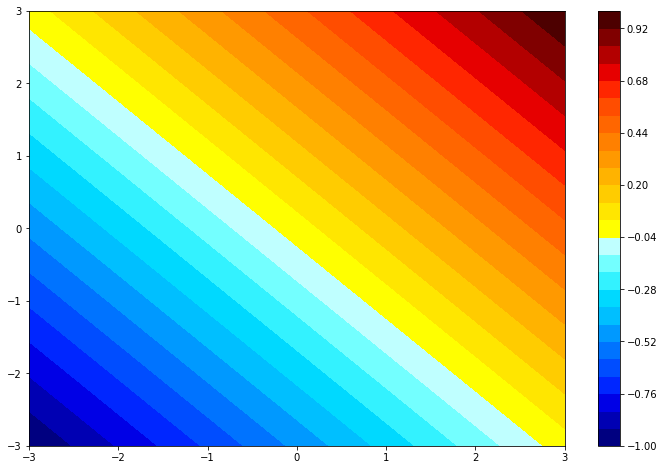

ready


In [65]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
gauss=x/6+y/6
clist=numpy.linspace(-1,1,26)
plt.contourf(x,y,gauss,clist,cmap=cmnew)
plt.colorbar()
plt.show()
print('ready')

In [66]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')

In [99]:
def plt_trends(lat, lon, obs):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)
    statnum = len(obs)
    hetcost = cost(lon, lat, obs)
    hetcost = np.nansum(hetcost) / np.sum(np.isfinite(obs))
    
    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    longitudes = lon
    latitudes = lat
    plt.scatter(longitudes, latitudes, s=40, alpha=1,
                c= obs,
                cmap=cmnew,
                vmin=0,
                vmax=30,
                edgecolor='k',)
#     plt.colorbar(orientation='horizontal', label='temperature uncertainty [K]', shrink=0.9, pad=0.05)
    plt.colorbar(orientation='horizontal', label='relative humidity uncertainty [%]', shrink=0.9, pad=0.05)

    plt.tight_layout()
#     plt.title('IGRA_H temperature_total_uncertainty, 2000, 100hPa'+'\n'+'heterogeneity cost function: '+'{:.2f}'.format(hetcost)+'\n'+'number of stations: '+str(statnum))
    plt.title('IGRA_H relative_humidity_total_uncertainty, 2000, 500hPa'+'\n'+'heterogeneity cost function: '+'{:.2f}'.format(hetcost)+'\n'+'number of stations: '+str(statnum))
    plt.savefig('plots_new/test.png', bbox_inches='tight')
    plt.close()

In [100]:
igra = 'insitu-observations-igra-baseline-network'
out = request({'source': 'IGRA_H',
#                'variable': 'air_temperature_total_uncertainty',
               'variable': 'relative_humidity_total_uncertainty',
               'year': '2000',
               'month': ['01','02','03','04','05','06','07','08','09','10','11','12'],
               'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],},igra, remove_file=True)
display(out)

2021-04-07 11:32:24,615 INFO Welcome to the CDS
2021-04-07 11:32:24,615 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-observations-igra-baseline-network
2021-04-07 11:32:25,466 INFO Request is completed
2021-04-07 11:32:25,466 INFO Downloading http://136.156.132.204/cache-compute-0001/cache/data1/adaptor.insitu_reference.retrieve_test-1617784913.4906816-25069-18-5cf353ff-b026-4a29-91c8-dff2f7d464c6.zip to download.zip (172.1M)
  0%|          | 199k/172M [00:00<01:33, 1.94MB/s]

Request took: 1.0067007541656494 seconds


2021-04-07 11:32:34,027 INFO Download rate 20.1M/s 


,station_name,report_timestamp,actual_time,report_id,longitude,latitude,height_of_station_above_sea_level,air_pressure,relative_humidity_total_uncertainty
index,,,,,,,,,
0,AUM00011240,2000-01-01,2000-01-01 03:44:00+00,82731,15.4392,46.993099,340.0,98500,NaN
1,AUM00011240,2000-01-01,2000-01-01 03:44:00+00,82731,15.4392,46.993099,340.0,71700,NaN
2,AUM00011240,2000-01-01,2000-01-01 03:44:00+00,82731,15.4392,46.993099,340.0,37000,NaN
3,AUM00011240,2000-01-01,2000-01-01 03:44:00+00,82731,15.4392,46.993099,340.0,50000,NaN
4,AUM00011240,2000-01-01,2000-01-01 03:44:00+00,82731,15.4392,46.993099,340.0,70000,NaN
...,...,...,...,...,...,...,...,...,...
13470086,TSM00060715,2000-01-01,1999-12-31 22:43:00+00,3119197,10.2333,36.833302,4.0,16200,NaN
13470087,TSM00060715,2000-01-01,1999-12-31 22:43:00+00,3119197,10.2333,36.833302,4.0,30000,NaN
13470088,TSM00060715,2000-01-01,1999-12-31 22:43:00+00,3119197,10.2333,36.833302,4.0,44700,NaN


In [101]:
# a = out[out.air_pressure == 10000]
a = out[out.air_pressure == 50000]

In [102]:
stats = np.asarray(a.station_name.drop_duplicates())
lat = []
lon = []
obs = []
for i in stats:
    dat = a[a.station_name == i]
#     obsmean = np.nanmean(dat.air_temperature_total_uncertainty)
    obsmean = np.nanmean(dat.relative_humidity_total_uncertainty)
    if not np.isnan(obsmean):
        obs.append(obsmean)
        lat.append(dat.latitude.iloc[0])
        lon.append(dat.longitude.iloc[0])
    

In [103]:
plt_trends(lat=np.asarray(lat), lon=np.asarray(lon), obs=np.asarray(obs))

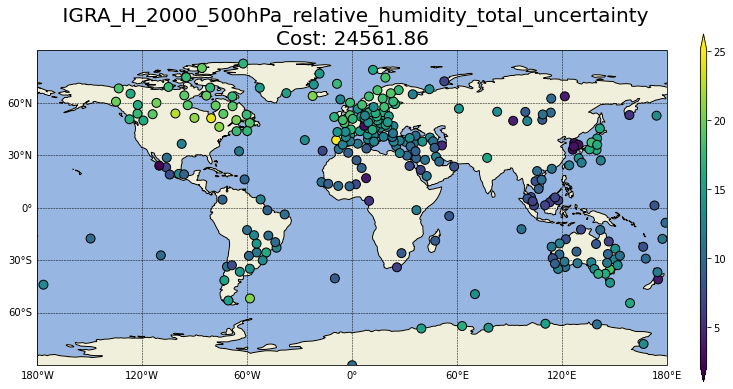

In [62]:
# # plot = points(lon=lon, lat=lat, values=obs, showtitle='IGRA_H_2000_100hPa_air_temperature_total_uncertainty', showcost=True,)
# plot = points(lon=lon, lat=lat, values=obs, showtitle='IGRA_H_2000_500hPa_relative_humidity_total_uncertainty', showcost=True,)
# fig = plot.get_figure()
# fig.savefig("output.png")